In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import LogFormatter
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import yaml
import netgraph

In [2]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

In [3]:
with open('../input/airport_dict.yaml', 'r') as yamlfile:
    airport_dict = yaml.load(yamlfile)

In [4]:
df['FiscalYear'] = df['MissionDate'].copy()
df.set_index('MissionDate', drop=False, inplace=True)
df.index.name = 'FiscalYear'

# Grouping records by exact date, fiscal year, MissionID,
# removal or transfer status, unique pickup/dropoff, juvenile status.
# Can't group by nationality here or it splits flights up and obscures trends
g = df.groupby([pd.Grouper(freq='AS-OCT'),
                'MissionDate',
                'R-T',
                'PULOC',
                'DropLoc',
                'air_LatitudeDecimalDegrees',
                'air_LongitudeDecimalDegrees',
                'air2_LatitudeDecimalDegrees',
                'air2_LongitudeDecimalDegrees'])

In [5]:
flights = g[['AlienMasterID']].nunique().reset_index()

In [6]:
# flights = flights[flights['FiscalYear'] == '2017-10-01']

In [7]:
flights.set_index('MissionDate', inplace=True)

In [8]:
# table.columns = ['year', 'R-T', 'pickup_airport', 'dropoff_airport', 'passengers', 'flights']
# all_kbfi = (table['pickup_airport'] == 'KBFI') | (table['dropoff_airport'] == 'KBFI')
# table.to_csv('../output/flight_summary.csv.gz', index=False, compression='gzip', encoding='utf-8', sep='|')

In [9]:
# flights = table
# flights = table[all_kbfi]
# flights = pd.read_csv('../output/flight_summary.csv.gz', compression='gzip', sep='|')
# flights = pd.read_csv('../output/guatemala_transfers.csv.gz', compression='gzip', sep='|')

In [10]:
# flights['pickup_airport'] = flights['pickup_airport'].str.upper()
# flights['dropoff_airport'] = flights['dropoff_airport'].str.upper()
# flights['pickup_airport'] = flights['PULOC'].str.upper()
# flights['dropoff_airport'] = flights['DropLoc'].str.upper()

In [11]:
flights_loc = set(pd.concat([flights['PULOC'], flights['DropLoc']]))

In [12]:
bad_airports = ['KKBL']

In [13]:
flights = flights[~flights['PULOC'].isin(bad_airports)]
flights = flights[~flights['DropLoc'].isin(bad_airports)]

In [14]:
# airports = pd.read_csv('../../share/hand/GlobalAirportDatabase.csv.gz', compression='gzip', sep='|')

In [15]:
# airports.head()

In [16]:
# airports_loc = set(airports['ICAOCode'])

In [17]:
# airports.set_index('ICAOCode', inplace=True)

In [18]:
# airports_missing_loc = ['FLKK', 'FWKI', 'KABQ', 'VTBS']

In [19]:
# airports = airports[~airports.index.isin(['FLKK', 'FWKI', 'KABQ', 'VTBS'])]

In [20]:
# additional_airports = pd.read_csv('../../share/hand/locations.csv', quotechar='"')

In [21]:
# additional_airports.columns = ['ICAOCode', 'CountryISO', 'State', 'City', 'LatitudeDecimalDegrees', 'LongitudeDecimalDegrees']
# additional_airports.set_index('ICAOCode', inplace=True)
# additional_airports.head()

In [22]:
# missing_airports = list(flights_loc.difference(airports_loc))
# missing_airports.extend(airports_missing_loc)

In [23]:
# airports_2 = additional_airports[additional_airports.index.isin(missing_airports)].copy()

In [24]:
# airports_2.head()

In [25]:
# airports_2 = airports_2[['LatitudeDecimalDegrees', 'LongitudeDecimalDegrees']]

In [26]:
# airports = pd.concat([airports, airports_2])

In [27]:
# arts_airports = list(set(df['PULOC'].append(df['DropLoc'])))

In [28]:
# airports_to_merge = airports[airports.index.isin(arts_airports)][['LatitudeDecimalDegrees', 'LongitudeDecimalDegrees']]

# # 

In [29]:
# airports_to_merge.to_csv('../output/airports_to_merge.csv')

In [30]:
# airports.head()

In [31]:
edges = flights[['PULOC', 'DropLoc']].values

In [32]:
edges

array([['KAEX', 'MHLM'],
       ['KBFL', 'KSAN'],
       ['KCSG', 'MSLP'],
       ...,
       ['KMSP', 'KAEX'],
       ['KOMA', 'KAEX'],
       ['KBRO', 'KAEX']], dtype=object)

In [33]:
g = nx.from_edgelist(edges)

In [34]:
len(g.nodes()), len(g.edges())

(221, 721)

In [35]:
sg = next(nx.connected_component_subgraphs(g))

In [36]:
list(nx.connected_component_subgraphs(g))[1].nodes

NodeView(('OLBA', 'KTEB'))

In [37]:
list(nx.connected_component_subgraphs(g))[2].nodes

NodeView(('NZWN', 'NFTF', 'YSSY', 'KSDM'))

In [38]:
airport_dict['KBFI']

{'AirportName': 'Boeing Field King County International Airport',
 'City': 'Seattle',
 'Country': 'USA',
 'LatitudeDecimalDegrees': 47.53,
 'LongitudeDecimalDegrees': -122.302,
 'State': 'WA'}

In [39]:
pos = {airport: (v['LongitudeDecimalDegrees'], v['LatitudeDecimalDegrees'])
       for airport, v in
       airport_dict.items()}

In [40]:
# Dropping unknown locations
pos_unknown = {k:v for k, v in pos.items() if v == (0.0, 0.0)}

In [41]:
# This is a dumb workaround to avoid issue with concatenating objects with different categories
# Do something to set each airport code column to include all airports instead?
flights['pickup'] = flights['PULOC'].astype(str)
flights['dropoff'] = flights['DropLoc'].astype(str)

In [42]:
airport_vars = pd.read_csv('../output/all_airport_vars.csv', index_col='Unnamed: 0')

In [43]:
airport_vars.tail()

,Airport Name,City,Country,Latitude,Longitude,Removal Percent,State,Total Dropoff Flights,Total Dropoffs,Total Flights,Total Passengers,Total Pickup Flights,Total Pickups,Total Removals,Total Transfers,Transfer Percent
VVTS,Tan So'n Nhat International Airport,Ho Chi Minh,Vietnam,10.820,106.662,100.0,NaN,5,73,5,73,0,0,73,0,0.0
VYYY,Yangon International Airport,Yangon,Myanmar,16.907,96.133,100.0,NaN,1,7,1,7,0,0,7,0,0.0
YSSY,Sydney Kingsford Smith Airport,Sydney,Australia,-33.946,151.177,100.0,NaN,1,2,1,2,0,0,2,0,0.0
ZBAA,Beijing Capital International Airport,Beijing,China,40.080,116.584,100.0,NaN,1,6,1,6,0,0,6,0,0.0
ZSFZ,Fuzhou Changle International Airport,Fuzhou,China,25.933,119.662,100.0,NaN,4,156,4,156,0,0,156,0,0.0


In [44]:
# khrl_kbro_avg = (airport_vars.loc['KHRL', 'removal_percent'] + airport_vars.loc['KBRO', 'removal_percent'])/2

In [45]:
# airport_vars.loc['KHRL-KBRO', 'removal_percent'] = khrl_kbro_avg

In [46]:
# airport_vars.loc['KBFI', 'removal_percent']

In [47]:
pickup_totals = flights.groupby('pickup')['AlienMasterID'].sum()
dropoff_totals = flights.groupby('dropoff')['AlienMasterID'].sum()

In [48]:
passenger_totals = pd.concat([pickup_totals, dropoff_totals])

In [49]:
passenger_totals['KHRL'].sum()

273673

In [50]:
passenger_totals['KBRO'].sum()

271328

In [51]:
passenger_totals['KHRL-KBRO'] = passenger_totals['KHRL'].sum() + passenger_totals['KBRO'].sum()

In [52]:
passenger_totals['KHRL-KBRO']

545001

In [53]:
pos['KHRL-KBRO'] = pos['KHRL']

In [54]:
passenger_totals = passenger_totals.drop(['KHRL', 'KBRO'])

In [55]:
passenger_totals.sum()

3465176

In [56]:
sg = nx.contracted_nodes(sg, 'KHRL', 'KBRO')

In [57]:
sg = nx.relabel_nodes(sg, {'KHRL': 'KHRL-KBRO'})

In [58]:
'KBRO' in sg.nodes

False

In [59]:
passenger_total = pd.Series(passenger_totals[icao].sum() for icao in sg.nodes)

In [60]:
removal_percent = pd.Series(airport_vars.loc[icao, 'removal_percent'] * 100 for icao in sg.nodes)

KeyError: 'the label [removal_percent] is not in the [index]'

In [ ]:
deg = nx.degree(sg)
sizes = [passenger_totals[icao].sum() / 500 for icao in sg.nodes]

In [ ]:
passenger_total.index = sg.nodes

In [ ]:
top_10_list = list(passenger_total.sort_values(ascending=False).head(10).index)

In [ ]:
top_10_list

In [ ]:
labels = {icao: icao if passenger_totals[icao].sum() >= 35000 else ''
          for icao in sg.nodes}
no_labels = {icao: '' for icao in sg.nodes}
top_10 = {icao: icao if icao in top_10_list else ''
          for icao in sg.nodes}

In [ ]:
pos['HKJK']

In [ ]:
# Map projection
crs = ccrs.PlateCarree(central_longitude=0)

fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw=dict(projection=crs))
# ax.stock_img()
ax.coastlines(alpha=.5)
ax.add_feature(cfeature.BORDERS, alpha=.5)
ax.add_feature(cfeature.STATES, alpha=.2)

# Extent of continental US.
ax.set_extent([-128, -62, 10, 50])
# Global
# ax.set_extent(ax.get_extent(crs))

cmap = plt.cm.viridis

nx.draw_networkx(sg, ax=ax,
                 font_size=16,
                 alpha=1,
                 width=.075,
                 node_size=sizes,
                 node_color=passenger_total,
                 labels=top_10,
                 pos=pos,
                 cmap=cmap)

vmin = passenger_total.min()
vmax = passenger_total.max()

l1 = plt.scatter([0],[0], s=(50000/500), c=[list(np.array(cmap(50000 / vmax)))], cmap=cmap, edgecolors='none')
l2 = plt.scatter([0],[0], s=(200000/500), c=[list(np.array(cmap(200000 / vmax)))], cmap=cmap, edgecolors='none')
l3 = plt.scatter([0],[0], s=(350000/500), c=[list(np.array(cmap(350000 / vmax)))], cmap=cmap, edgecolors='none')
l4 = plt.scatter([0],[0], s=(550000/500), c=[list(np.array(cmap(550000 / vmax)))], cmap=cmap, edgecolors='none')

labels = ["50K", "150K", "350K", "550K"]

lgd = plt.legend([l1, l2, l3, l4], labels, ncol=4, frameon=True, fontsize=12,
handlelength=2, loc = 9, borderpad = 1,
handletextpad=1, title='Total passengers', scatterpoints = 1)


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, shrink=.8)
plt.title("ICE Air: Total passengers per airport and flight paths", size=18)

msg = "(KHRL & KBRO airports combined for clarity)"
txt = plt.figtext(0.29, 0.2, msg, wrap=True, horizontalalignment='center', fontsize=12)

msg = '(Source: UW Center for Human Rights, ICE Air ARTS database)'
txt = plt.figtext(0.65, .125, msg, wrap=True, horizontalalignment='center', fontsize=12)

fig.savefig(f'../output/map-total-passengers.png', dpi=100, bbox_extra_artists=(lgd,txt), bbox_inches='tight')

plt.show()

In [ ]:
# Map projection
crs = ccrs.PlateCarree(central_longitude=0.0)

fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw=dict(projection=crs))
# ax.stock_img()
ax.coastlines(alpha=.5)
ax.add_feature(cfeature.BORDERS, alpha=.5)
ax.add_feature(cfeature.STATES, alpha=.2)

# Extent of continental US.
ax.set_extent([-128, -62, 10, 50])
# Global
# ax.set_extent([-180, 180, -60, 90])

cmap = plt.cm.viridis

nx.draw_networkx(sg, ax=ax,
                 font_size=16,
                 alpha=1,
                 width=0.05,
                 node_size=sizes,
                 node_color=removal_percent,
                 labels=no_labels,
                 pos=pos,
                 cmap=cmap)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=100))
sm._A = []
plt.colorbar(sm, shrink=.8)
plt.title("Removals as percent of passengers for ICE Air airports", size=18)

txt="(KHRL & KBRO airports combined for clarity)"
plt.figtext(0.29, 0.2, txt, wrap=True, horizontalalignment='center', fontsize=12)

fig.savefig(f'../output/map-removal-percent.png', dpi=100, bbox_inches='tight')

plt.show()

# Choropleth

In [ ]:
cmap = mpl.cm.Blues
# Countries is a dictionary of {"country_name": number of users}, for example
countries = df[df['R-T'] == 'R'].groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique().to_dict()

min_passengers = float(min(countries.values()))
max_passengers = float(max(countries.values()))
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()

for country in shpreader.Reader(countries_shp).records():
    name = country.attributes['NAME_LONG'].upper()
    try:
        num_passengers = countries[name]
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                    facecolor=cmap(np.log(num_passengers)/np.log(max_passengers)))
    except:
        num_passengers = 0
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                    facecolor=cmap(num_passengers))
        pass

# formatter = LogFormatter(labelOnlyBase=False) 
    
sm = plt.cm.ScalarMappable(cmap=cmap,norm=colors.LogNorm(vmin=1, vmax=max_passengers))
sm._A = []
plt.colorbar(sm, ax=ax, shrink=.66, extend='max')

plt.title('ICE Air global removals (logged),\nOct. 2010 - Dec. 2018')

plt.savefig('../output/removal_choropleth.png', transparent=True, dpi=900)

## Directed graph

In [61]:
airport = 'KOAK'

PU = df['PULOC'] == airport
DO = df['DropLoc'] == airport

air_pickups = df[PU].groupby([pd.Grouper(freq='AS-OCT'),
                'R-T',
                'PULOC',
                'DropLoc',
                'air_LatitudeDecimalDegrees',
                'air_LongitudeDecimalDegrees',
                'air2_LatitudeDecimalDegrees',
                'air2_LongitudeDecimalDegrees'])['AlienMasterID'].nunique().reset_index()
air_dropoffs = df[DO].groupby([pd.Grouper(freq='AS-OCT'),
                'R-T',
                'PULOC',
                'DropLoc',
                'air_LatitudeDecimalDegrees',
                'air_LongitudeDecimalDegrees',
                'air2_LatitudeDecimalDegrees',
                'air2_LongitudeDecimalDegrees'])['AlienMasterID'].nunique().reset_index()
air_all = df[PU | DO].groupby([pd.Grouper(freq='AS-OCT'),
                'R-T',
                'PULOC',
                'DropLoc',
                'air_LatitudeDecimalDegrees',
                'air_LongitudeDecimalDegrees',
                'air2_LatitudeDecimalDegrees',
                'air2_LongitudeDecimalDegrees'])['AlienMasterID'].nunique().reset_index()

In [62]:
air_pickups.set_index('FiscalYear', inplace=True)
air_dropoffs.set_index('FiscalYear', inplace=True)
air_all.set_index('FiscalYear', inplace=True)

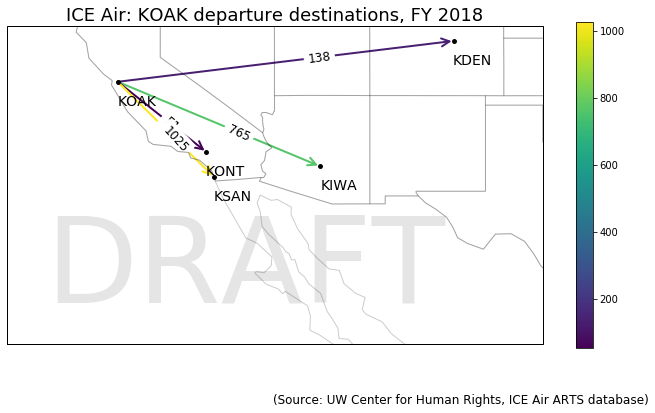

In [67]:
year = '2017'
vmax = air_all[year].groupby(['PULOC', 'DropLoc'])['AlienMasterID'].sum().max()
vmin = air_all[year].groupby(['PULOC', 'DropLoc'])['AlienMasterID'].sum().min()

if pd.notnull(year):
    edges = air_pickups[year][['PULOC', 'DropLoc']].values
    weights = air_pickups[year].groupby(['PULOC', 'DropLoc'])['AlienMasterID'].sum().reset_index()
else:
    edges = air_pickups[['PULOC', 'DropLoc']].values
    weights = air_pickups.groupby(['PULOC', 'DropLoc'])['AlienMasterID'].sum().reset_index()

G = nx.DiGraph()

for row in weights.values:
    G.add_edge(row[0], row[1], weight=row[2])
    
weights = pd.Series([c for (u, v, c) in G.edges.data('weight', default=0)])

# sizes = [passenger_totals[icao].sum() / 500 for icao in G.nodes]

pos_higher = {}
y_off = -1  # offset on the y axis
x_off = 1
air_y_off = 1
air_x_off = 1

for k, v in pos.items():
    if k == 'air':
        pos_higher[k] = (v[0]+air_x_off, v[1]+air_y_off)
    else:
        pos_higher[k] = (v[0]+x_off, v[1]+y_off)
        
labels = {icao: icao for icao in G.nodes}
edge_weights = {edge: G.get_edge_data(edge[0], edge[1])['weight'] for edge in G.edges}

# Map projection
crs = ccrs.PlateCarree(central_longitude=0.0)

fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw=dict(projection=crs))
ax.coastlines(alpha=.2)
ax.add_feature(cfeature.BORDERS, alpha=.2)
ax.add_feature(cfeature.STATES, alpha=.2)

# Extent of continental US.
# ax.set_extent([-128, -62, 10, 50])
# KBFI
# ax.set_extent([-128, -90, 24, 50])
# KCSG
# ax.set_extent([-118, -62, 10, 40]) 
# KOAK
ax.set_extent([-128, -100, 24, 40])

M = G.number_of_edges()
edge_colors = [weight / max(weights) for weight in weights]
edge_alphas = 1

nodes = nx.draw_networkx_nodes(G, pos, ax=ax, node_size=15, node_color='black')
edges = nx.draw_networkx_edges(G, pos, ax=ax, node_size=15, arrowstyle='->',
                               arrowsize=20,
                               edge_color=edge_colors,
                               edge_cmap=plt.cm.viridis,
                               width=2)
edge_labels=nx.draw_networkx_edge_labels(G,pos, edge_labels=edge_weights, label_pos=.4, font_size=12)
labels = nx.draw_networkx_labels(G, pos_higher, ax=ax, labels=labels, font_size=14)

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.viridis,
                                     norm=plt.Normalize(vmin=vmin, vmax=vmax))
pc.set_array(edge_colors)
plt.colorbar(pc, ax=ax, shrink=.75)

plt.title(f"ICE Air: {airport} departure destinations, FY {int(year)+1}", size=18)

msg = '(Source: UW Center for Human Rights, ICE Air ARTS database)'
txt = plt.figtext(0.65, .125, msg, wrap=True, horizontalalignment='center', fontsize=12)
draft = plt.figtext(.4, .3, 'DRAFT', wrap=True, horizontalalignment='center', fontsize=120, alpha=.1)

fig.savefig(f'../output/map-{airport}-destinations.png', dpi=100, bbox_extra_artists=(pc,txt), bbox_inches='tight')

ax = plt.gca()
ax.set_axis_off()
plt.show()

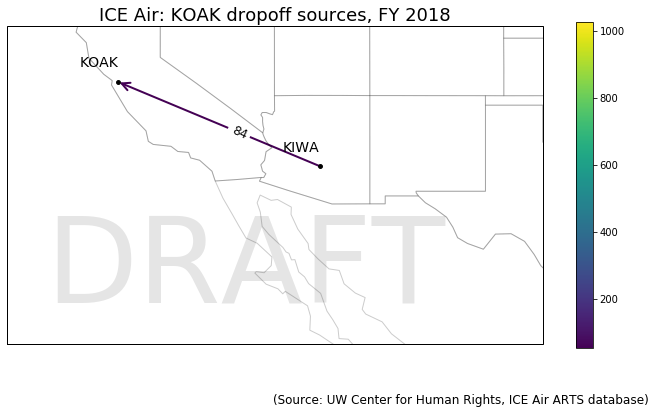

In [69]:
year = '2017'
vmax = air_all[year].groupby(['PULOC', 'DropLoc'])['AlienMasterID'].sum().max()
vmin = air_all[year].groupby(['PULOC', 'DropLoc'])['AlienMasterID'].sum().min()

if pd.notnull(year):
    edges = air_dropoffs[year][['PULOC', 'DropLoc']].values
    weights = air_dropoffs[year].groupby(['PULOC', 'DropLoc'])['AlienMasterID'].sum().reset_index()
else:
    edges = air_dropoffs[['PULOC', 'DropLoc']].values
    weights = air_dropoffs.groupby(['PULOC', 'DropLoc'])['AlienMasterID'].sum().reset_index()

G = nx.DiGraph()

for row in weights.values:
    G.add_edge(row[0], row[1], weight=row[2])
    
weights = pd.Series([c for (u, v, c) in G.edges.data('weight', default=0)])

# sizes = [passenger_totals[icao].sum() / 500 for icao in G.nodes]

pos_higher = {}
y_off = 1
x_off = -1
air_y_off = 1
air_x_off = 1

for k, v in pos.items():
    if k == 'air':
        pos_higher[k] = (v[0]+air_x_off, v[1]+air_y_off)
    else:
        pos_higher[k] = (v[0]+x_off, v[1]+y_off)
        
labels = {icao: icao for icao in G.nodes}
edge_weights = {edge: G.get_edge_data(edge[0], edge[1])['weight'] for edge in G.edges}

special_edge = ('KSAT', 'KBFI')
special_edge_weights = {special_edge: edge_weights.pop(special_edge, None)}

# Map projection
crs = ccrs.PlateCarree(central_longitude=0.0)

fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw=dict(projection=crs))
ax.coastlines(alpha=.2)
ax.add_feature(cfeature.BORDERS, alpha=.2)
ax.add_feature(cfeature.STATES, alpha=.2)


# Extent of continental US.
# ax.set_extent([-128, -62, 10, 50])
# KBFI
# ax.set_extent([-128, -90, 24, 50])
# KCSG
# ax.set_extent([-114, -75, 18, 36]) 
# KOAK
ax.set_extent([-128, -100, 24, 40])

M = G.number_of_edges()
edge_colors = [weight / max(weights) for weight in weights]
edge_alphas = 1

nodes = nx.draw_networkx_nodes(G, pos, ax=ax, node_size=15, node_color='black')
edges = nx.draw_networkx_edges(G, pos, ax=ax, node_size=15, arrowstyle='->',
                               arrowsize=20,
                               edge_color=edge_colors,
                               edge_cmap=plt.cm.viridis,
                               width=2)
labels = nx.draw_networkx_labels(G, pos_higher, ax=ax, labels=labels, font_size=14)
edge_labels=nx.draw_networkx_edge_labels(G, pos, label_pos=.6, edge_labels=edge_weights, font_size=12)
# edge_labels=nx.draw_networkx_edge_labels(G, pos, label_pos=.8, edge_labels=special_edge_weights, font_size=12)

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.viridis,
                                     norm=plt.Normalize(vmin=vmin, vmax=vmax))
pc.set_array(edge_colors)
plt.colorbar(pc, ax=ax, shrink=.75)

plt.title(f"ICE Air: {airport} dropoff sources, FY {int(year)+1}", size=18)
msg = '(Source: UW Center for Human Rights, ICE Air ARTS database)'
txt = plt.figtext(0.65, .125, msg, wrap=True, horizontalalignment='center', fontsize=12)
draft = plt.figtext(.4, .3, 'DRAFT', wrap=True, horizontalalignment='center', fontsize=120, alpha=.1)

fig.savefig(f'../output/map-{airport}-sources.png', dpi=100, bbox_extra_artists=(pc,txt), bbox_inches='tight')

ax = plt.gca()
ax.set_axis_off()
plt.show()

### Netgraph experiment

In [ ]:
year = '2017'
if pd.notnull(year):
    edges = kbfi_all[year][['PULOC', 'DropLoc']].values
    weights = kbfi_all[year].groupby(['PULOC', 'DropLoc'])['AlienMasterID'].sum().reset_index()
else:
    edges = kbfi_all[['PULOC', 'DropLoc']].values
    weights = kbfi_all.groupby(['PULOC', 'DropLoc'])['AlienMasterID'].sum().reset_index()

G = nx.DiGraph()

for row in weights.values:
    G.add_edge(row[0], row[1], weight=row[2])
    
weights = pd.Series([c for (u, v, c) in G.edges.data('weight', default=0)])

# sizes = [passenger_totals[icao].sum() / 500 for icao in G.nodes]

pos_higher = {}
y_off = -1
x_off = 2.66
kbfi_y_off = 1
kbfi_x_off = 1

for k, v in pos.items():
    if k == 'KBFI':
        pos_higher[k] = (v[0]+kbfi_x_off, v[1]+kbfi_y_off)
    else:
        pos_higher[k] = (v[0]+x_off, v[1]+y_off)
        
labels = {icao: icao for icao in G.nodes}
edge_weights = {edge: G.get_edge_data(edge[0], edge[1])['weight'] for edge in G.edges}

# Map projection
crs = ccrs.PlateCarree(central_longitude=0.0)

fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw=dict(projection=crs))
ax.coastlines(alpha=.2)
ax.add_feature(cfeature.BORDERS, alpha=.2)

# Extent of continental US.
ax.set_extent([-128, -62, 10, 50])

M = G.number_of_edges()
edge_colors = [weight / max(weights) for weight in weights]
edge_alphas = 1

net = netgraph.draw(G, pos,
                    ax=ax,
                    width=20,
                    edge_width=20,
                    edge_color='black',
                    node_edge_width=1,
                    node_edge_alpha=0)

# nodes = netgraph.draw_nodes(G, pos, ax=ax, node_size=15, node_color='black')
# edges = netgraph.draw_edges(G, pos, ax=ax, node_size=15, arrowstyle='->',
#                                arrowsize=20,
#                                edge_color=edge_colors,
#                                edge_cmap=plt.cm.viridis,
#                                width=np.log(weights)/2+.25)
# edge_labels=nx.draw_networkx_edge_labels(G, pos, label_pos=.8, edge_labels=edge_weights,
#                                         bbox=dict(facecolor='white', edgecolor='black'))
# labels = nx.draw_networkx_labels(G, pos_higher, ax=ax, labels=labels, font_size=14)

# pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.viridis,
#                                      norm=plt.Normalize(vmin=weights.min(), vmax=weights.max()))
# pc.set_array(edge_colors)
# plt.colorbar(pc, ax=ax, shrink=.75)

plt.title(f"ICE Air: Boeing Field, FY {int(year)+1}", size=18)
ax = plt.gca()
ax.set_axis_off()
plt.show()

### Experiment with multiple axes

In [ ]:
# Map projection
crs = ccrs.PlateCarree(central_longitude=0.0)

fig, ax = plt.subplots(
    1, 2, figsize=(12, 8),
    subplot_kw=dict(projection=crs))

for i, ax in enumerate(fig.axes):
    fig.axes[i].coastlines(alpha=.2)
    fig.axes[i].add_feature(cfeature.BORDERS, alpha=.2)
    fig.axes[i].set_extent([-128, -90, 10, 50])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.viridis,
                                     norm=plt.Normalize(vmin=vmin, vmax=vmax))
pc.set_array(edge_colors)
plt.colorbar(pc, shrink=.75)